# <font color='darkblue'>Setup</font> 

In [108]:
# Packages -----------------------------------------------#

# Data Analysis
import xarray as xr
import numpy as np
import pandas as pd
from scipy import stats
from scipy.ndimage import gaussian_filter

# Plotting
import cartopy.crs as ccrs
from cartopy.feature import LAND
import cartopy.feature as cfeature
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import matplotlib.pyplot as mpl

# Timing Processes
import time

# make sure the figures plot inline rather than at the end
%matplotlib inline

# Get Data ----------------------------------------------#

# get data from tigress - currently this is Liao's
path = '/home/jennap/projects/LRGROUP/shared_data/Merged_ARGO_WOD_GOSHIP/'
infn = 'Profiles_temp_psal_doxy.nc'

ds = xr.open_dataset(path + infn)
# print(ds.keys())

# change time variable ----------------------------------#
# set the units to be something xarray can decode
ds.time.attrs['units'] = 'days since 01-01-1800'
#re-decode the dataset
ds = xr.decode_cf(ds)

# <font color='darkblue'>Quality Control</font> 

In [191]:
# remove shelf
shelf_pres_cutoff = 300

# take only data that is below this pressure level
below_shelf_temp = ds.temp[:,ds.pres >= shelf_pres_cutoff];
below_shelf_doxy = ds.doxy[:,ds.pres >= shelf_pres_cutoff];

# find if all the data are nans below this
below_shelf_temp_ind = (np.sum(~np.isnan(below_shelf_temp),1) <1)
below_shelf_doxy_ind = (np.sum(~np.isnan(below_shelf_doxy),1) <1)

# set the whole columns to those on the shelf to NaNs
ds.temp[below_shelf_temp_ind,:] = np.nan;
ds.doxy[below_shelf_doxy_ind,:] = np.nan;

# find data above 500dbars
upper_temp = ds.temp[:,ds.pres<500]
upper_doxy = ds.doxy[:,ds.pres<500]

# set profiles with less than 10 points in upper ocean to nans
temp_qc = ds.temp
temp_ind = (np.sum(~np.isnan(upper_temp),1) <20)
temp_qc[temp_ind,:] = np.nan

doxy_qc = ds.doxy
doxy_ind = (np.sum(~np.isnan(upper_doxy),1) <20)
doxy_qc[doxy_ind,:] = np.nan

#add to dataset
ds['temp_qc'] = temp_qc
ds['doxy_qc'] = doxy_qc

In [192]:
# Find one-sided dT/dp and dO/dp
temp_grad = temp_qc.diff("pres")/ds.pres.diff("pres")
doxy_grad = doxy_qc.diff("pres")/ds.pres.diff("pres")

# average pressures
pres_grad = (np.array(ds.pres[1:]) + np.array(ds.pres[:-1]))/2

#add to dataset
ds['temp_grad'] = xr.DataArray(temp_grad,dims = ['prof','pres_grad'],coords =[ds.prof,pres_grad])
ds['doxy_grad'] = xr.DataArray(doxy_grad,dims = ['prof','pres_grad'],coords =[ds.prof,pres_grad])

# lightly smooth profiles
temp_grad_sm_10 = ds.temp_grad.rolling(pres_grad=11, center=True).mean()
doxy_grad_sm_10 = ds.doxy_grad.rolling(pres_grad=11, center=True).mean()

#add to dataset
ds['temp_grad_sm_10'] = xr.DataArray(temp_grad_sm_10,dims = ['prof','pres_grad'],coords =[ds.prof,pres_grad])
ds['doxy_grad_sm_10'] = xr.DataArray(doxy_grad_sm_10,dims = ['prof','pres_grad'],coords =[ds.prof,pres_grad])


In [193]:
#mask the nans in the arrays so that the functions work as expected 
temp_grad = np.ma.masked_array(ds.temp_grad, np.isnan(ds.temp_grad))
doxy_grad = np.ma.masked_array(ds.doxy_grad, np.isnan(ds.doxy_grad))

temp_grad_sm_10 = np.ma.masked_array(ds.temp_grad_sm_10, np.isnan(ds.temp_grad_sm_10))
doxy_grad_sm_10 = np.ma.masked_array(ds.doxy_grad_sm_10, np.isnan(ds.doxy_grad_sm_10))

# find maximum negative gradients (min grad)
temp_grad_min_ind = np.nanargmin(temp_grad,1)
doxy_grad_min_ind = np.nanargmin(doxy_grad,1)

temp_grad_sm_10_min_ind = np.nanargmin(temp_grad_sm_10,1)
doxy_grad_sm_10_min_ind = np.nanargmin(doxy_grad_sm_10,1)

# take the pressure value at the min index
TCD = pres_grad[temp_grad_min_ind]
OCD = pres_grad[doxy_grad_min_ind]

TCD_sm_10 = pres_grad[temp_grad_sm_10_min_ind]
OCD_sm_10 = pres_grad[doxy_grad_sm_10_min_ind]

#set places where profiles were all nans to nan
TCD[np.sum(~np.isnan(temp_qc),1) <1] = np.nan
OCD[np.sum(~np.isnan(doxy_qc),1) <1] = np.nan

TCD_sm_10[np.sum(~np.isnan(temp_qc),1) <1] = np.nan
OCD_sm_10[np.sum(~np.isnan(doxy_qc),1) <1] = np.nan

# set all values that are lower than 500dbar to nan
TCD[TCD > 500] = np.nan
OCD[OCD > 500] = np.nan

TCD_sm_10[TCD_sm_10 > 500] = np.nan
OCD_sm_10[OCD_sm_10 > 500] = np.nan

#add to dataset
ds['TCD'] = xr.DataArray(TCD,dims = ['prof'],coords =[ds.prof])
ds['OCD'] = xr.DataArray(OCD,dims = ['prof'],coords =[ds.prof])

ds['TCD_sm_10'] = xr.DataArray(TCD_sm_10,dims = ['prof'],coords =[ds.prof])
ds['OCD_sm_10'] = xr.DataArray(OCD_sm_10,dims = ['prof'],coords =[ds.prof])


/home/jennap/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in greater
/home/jennap/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in greater
/home/jennap/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in greater
/home/jennap/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


# Compare Profiles and TCD/OCD for different regions

/home/jennap/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in greater
  import sys
/home/jennap/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  
/home/jennap/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in greater
  if __name__ == '__main__':
/home/jennap/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in greater
  # Remove the CWD from sys.path while we load stuff.


Text(0.5, 1.0, 'Unsmoothed Temperature and TCD')

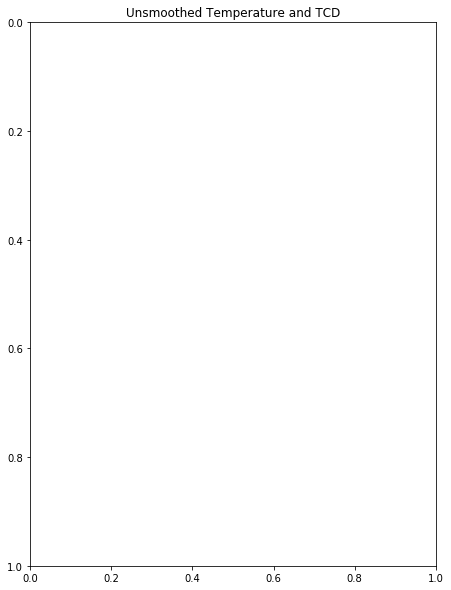

In [194]:
fig = plt.figure(figsize = (16,10))

ax = plt.subplot(1,2,1)

#subset data
thresh = 400
boxlat = ds.lat[TCD > thresh]
boxlon = ds.lon[TCD > thresh]
boxtemp = ds.temp[TCD > thresh,:]
boxTCD = ds.TCD[TCD > thresh]

for pr in range(boxtemp.shape[0]):
    p = ax.plot(boxtemp[pr,:],ds.pres,'.')
    plt.hlines(boxTCD[pr],0,18)
ax.set_ylim(ax.get_ylim()[::-1])
ax.set_title('Unsmoothed Temperature and TCD')

In [195]:
# # Define bounding box
# eAS = [5,30,40,65]
# wAS = [5,30,65,80]
# eBoB = [5,30,80,90]
# wBoB = [5,30,90,100]

# # plot titles
# titles = ['West AS','East AS','West BoB','East BoB']
# locs = [wAS,eAS,wBoB,eBoB]

# fig = plt.figure(figsize = (16,20))

# for ll,loc in enumerate(locs):
    
#     ax = plt.subplot(3,2,ll+1)
#     #subset data
#     ind = (ds.lat > loc[0]) & (ds.lat < loc[1]) & (ds.lon > loc[2]) & (ds.lon < loc[3])
#     boxlat = ds.lat[ind]
#     boxlon = ds.lon[ind]
#     boxtemp = ds.temp[ind,:]
#     for pr in range(boxtemp.shape[0]):
#         p = ax.plot(boxtemp[pr,:],ds.pres)
#         plt.hlines(ds.TCD[pr],0,18)
#     ax.set_ylim(ax.get_ylim()[::-1])
#     ax.set_title('Unsmoothed Temperature and TCD ' + titles[ll])

In [196]:
# # Define bounding box
# eAS = [5,30,40,65]
# wAS = [5,30,65,80]
# eBoB = [5,30,80,90]
# wBoB = [5,30,90,100]

# # plot titles
# titles = ['West AS','East AS','West BoB','East BoB']
# locs = [wAS,eAS,wBoB,eBoB]

# fig = plt.figure(figsize = (16,20))

# for ll,loc in enumerate(locs):
    
#     ax = plt.subplot(3,2,ll+1)
#     #subset data
#     ind = (ds.lat > loc[0]) & (ds.lat < loc[1]) & (ds.lon > loc[2]) & (ds.lon < loc[3])
#     boxlat = ds.lat[ind]
#     boxlon = ds.lon[ind]
#     boxdoxy = ds.doxy[ind,:]
#     for pr in range(boxdoxy.shape[0]):
#         p = ax.plot(boxdoxy[pr,:],ds.pres)
# #         plt.hlines(ds.OCD[pr],0,18)
#     ax.set_ylim(ax.get_ylim()[::-1])
#     ax.set_title('Unsmoothed Oxygen and OCD ' + titles[ll])

## Scatterplots

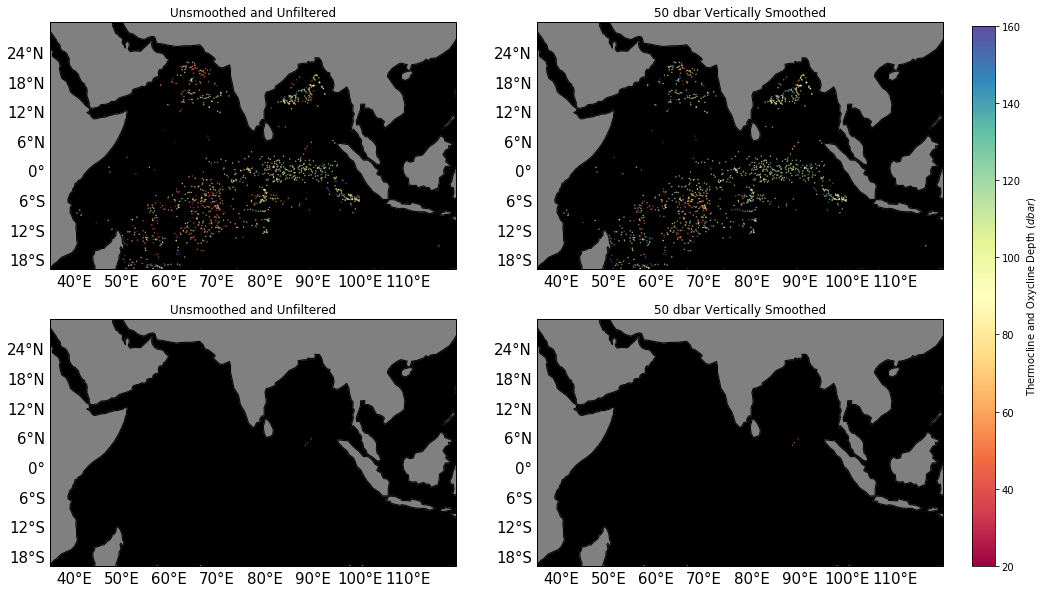

In [197]:
# Plotting
def add_land(ax,bounds):
    from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
    ax.add_feature(cfeature.LAND,color='gray',zorder = 1)
    ax.background_patch.set_facecolor('k')
    ax.coastlines(resolution='110m',zorder = 2)
    g = ax.gridlines(draw_labels=True,alpha=0)
    g.xlabels_top = False
    g.ylabels_right = False
    g.xlabel_style = {'size': 15}
    g.ylabel_style = {'size': 15}
    g.xformatter = LONGITUDE_FORMATTER
    g.yformatter = LATITUDE_FORMATTER
    ax.axes.axis('tight')
    ax.set_extent(bounds, crs=ccrs.PlateCarree())

# limits 
cmin = 20
cmax = 160
bounds = [35,120,-20,30]
sz = .5
cmap = plt.cm.Spectral # plt.cm.PuOr

fig, axes = plt.subplots(nrows = 2, ncols = 2,figsize=(16,10),subplot_kw={'projection': ccrs.PlateCarree()})

p = axes[0,0].scatter(ds.lon,ds.lat,s=sz,marker = '.',c=ds.TCD,cmap=cmap,vmin=cmin,vmax=cmax,
                       transform=ccrs.PlateCarree())
add_land(axes[0,0],bounds)
axes[0,0].set_title('Unsmoothed and Unfiltered')
axes[0,0].set_xlabel('Longitude')
axes[0,0].set_ylabel('Latitude')


p2 = axes[0,1].scatter(ds.lon,ds.lat,s=sz,marker = '.',c=ds.TCD_sm_10,cmap=cmap, vmin=cmin,vmax=cmax,
                       transform=ccrs.PlateCarree())
add_land(axes[0,1],bounds)
axes[0,1].set_title('50 dbar Vertically Smoothed')
axes[0,1].set_xlabel('Longitude')

p4 = axes[1,0].scatter(ds.lon,ds.lat,s=sz,marker = '.',c=ds.OCD,cmap=cmap,vmin=cmin,vmax=cmax,
                       transform=ccrs.PlateCarree())
add_land(axes[1,0],bounds)
axes[1,0].set_title('Unsmoothed and Unfiltered')
axes[1,0].set_xlabel('Longitude')
axes[1,0].set_ylabel('Latitude')


p5 = axes[1,1].scatter(ds.lon,ds.lat,s=sz,marker = '.',c=ds.OCD_sm_10,cmap=cmap, vmin=cmin,vmax=cmax,
                       transform=ccrs.PlateCarree())
add_land(axes[1,1],bounds)
axes[1,1].set_title('50 dbar Vertically Smoothed')
axes[1,1].set_xlabel('Longitude')


cbar_ax = fig.add_axes([0.925, 0.125, 0.02, 0.75])
cbar = fig.colorbar(p,cax=cbar_ax, pad=0.04)
cbar.set_label('Thermocline and Oxycline Depth ($dbar$)')

### Binned Maps

https://stackoverflow.com/questions/40465026/groupby-bins-on-two-variables

In [198]:
def latlonbin(invar,lat,lon,date,binwidth):
    import numpy as np
    
    # create a pandas dataframe
    df = pd.DataFrame(dict(
            invar = np.array(invar),
            lat= np.array(lat),
            lon= np.array(lon),
            date = np.array(date)
        ))
    
    # # add in a column for the month
    df['month'] = pd.DatetimeIndex(df['date']).month

    # create 1 degree bins
    latedges = np.arange(lat.min()-(binwidth/2),lat.max()+(binwidth/2),binwidth)
    lat_inds = list(range(len(latedges)-1))

    lonedges = np.arange(lon.min()-(binwidth/2),lon.max()+(binwidth/2),binwidth)
    lon_inds = list(range(len(lonedges)-1))

    latbins = latedges[1:]-(binwidth/2)
    lonbins = lonedges[1:]-(binwidth/2)

    df['latedges'] = pd.cut(lat, latedges)
    df['lonedges'] = pd.cut(lon, lonedges)
    df['latbins_ind'] = pd.cut(lat, latedges,labels = lat_inds)
    df['lonbins_ind'] = pd.cut(lon, lonedges,labels = lon_inds)
    df['lat_lon_indx']=df.groupby(['latbins_ind', 'lonbins_ind']).ngroup()
    grouped = df.groupby(['latbins_ind', 'lonbins_ind'])

    invar_BINNED = np.zeros((len(latbins),len(lonbins)), dtype=np.ndarray)
    invar_BINNED[:] = np.nan

    invar_binned_ave = np.zeros((len(latbins),len(lonbins)), dtype=np.ndarray)
    invar_binned_ave[:] = np.nan


    #extract the data for each group
    for name, group in grouped:
        i = np.array(group.latbins_ind)
        j = np.array(group.lonbins_ind)

        invar_BINNED[i[0],j[0]] = group.invar

        invar_binned_ave[i[0],j[0]] = np.nanmean(group.invar)
        
    # create pcolormesh lat/lon vals
    
    # extend longitude by 2
    lon_extend = np.zeros(lonbins.size+2)
    # fill in internal values
    lon_extend[1:-1] = lonbins # fill up with original values
    # fill in extra endpoints
    lon_extend[0] = lonbins[0]-np.diff(lonbins)[0]
    lon_extend[-1] = lonbins[-1]+np.diff(lonbins)[-1]
    # calculate the midpoints
    lon_pcolormesh_midpoints = lon_extend[:-1]+0.5*(np.diff(lon_extend))

    # extend latitude by 2
    lat_extend = np.zeros(latbins.size+2)
    # fill in internal values
    lat_extend[1:-1] = latbins
    # fill in extra endpoints
    lat_extend[0] = latbins[0]-np.diff(latbins)[0]
    lat_extend[-1] = latbins[-1]+np.diff(latbins)[-1]
    # calculate the midpoints
    lat_pcolormesh_midpoints = lat_extend[:-1]+0.5*(np.diff(lat_extend))
    

    return(np.array(invar_binned_ave,dtype = float), 
           lonbins,latbins,lon_pcolormesh_midpoints,lat_pcolormesh_midpoints)



In [199]:
binwidth = 1

# TCD/OCD Binned
TCD_binned_ave, lonbins, latbins,lonp,latp = latlonbin(ds.TCD,ds.lat,ds.lon,ds.time,binwidth)
OCD_binned_ave,_,_,_,_ = latlonbin(ds.OCD,ds.lat,ds.lon,ds.time,binwidth)

TCD_sm_10_binned_ave, lonbins, latbins,lonp,latp = latlonbin(ds.TCD_sm_10,ds.lat,ds.lon,ds.time,binwidth)
OCD_sm_10_binned_ave,_,_,_,_ = latlonbin(ds.OCD_sm_10,ds.lat,ds.lon,ds.time,binwidth)
    
# add to dataset
ds['TCD_binned_ave'] = xr.DataArray(TCD_binned_ave,
                                   dims = ['latbins','lonbins'],coords =[latbins,lonbins])

ds['OCD_binned_ave'] = xr.DataArray(OCD_binned_ave,
                                   dims = ['latbins','lonbins'],coords =[latbins,lonbins])

# add to dataset
ds['TCD_sm_10_binned_ave'] = xr.DataArray(TCD_sm_10_binned_ave,
                                   dims = ['latbins','lonbins'],coords =[latbins,lonbins])

ds['OCD_sm_10_binned_ave'] = xr.DataArray(OCD_sm_10_binned_ave,
                                   dims = ['latbins','lonbins'],coords =[latbins,lonbins])



/home/jennap/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: Mean of empty slice
/home/jennap/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: Mean of empty slice
/home/jennap/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: Mean of empty slice
/home/jennap/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: Mean of empty slice


## Plots of Binned and Vertically Smoothed

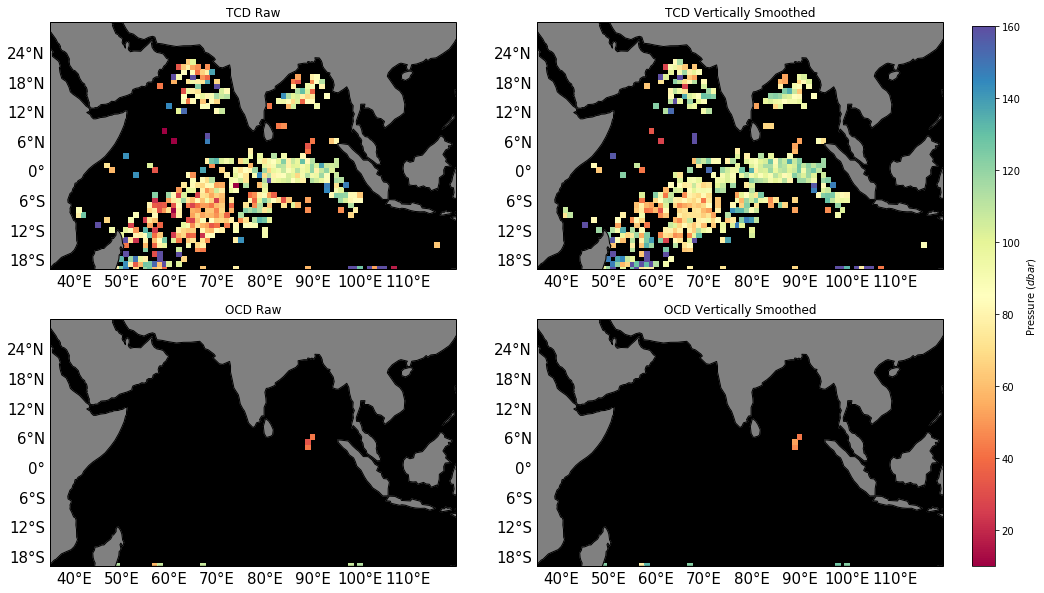

In [200]:
# Plotting
def add_land(ax,bounds):
    from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
    ax.add_feature(cfeature.LAND,color='gray',zorder = 2)
    ax.background_patch.set_facecolor('k')
    ax.coastlines(resolution='110m',zorder = 2)
    g = ax.gridlines(draw_labels=True,alpha=0)
    g.xlabels_top = False
    g.ylabels_right = False
    g.xlabel_style = {'size': 15}
    g.ylabel_style = {'size': 15}
    g.xformatter = LONGITUDE_FORMATTER
    g.yformatter = LATITUDE_FORMATTER
    ax.axes.axis('tight')
    ax.set_extent(bounds, crs=ccrs.PlateCarree())

# limits
cmin = 10
cmax =160
bounds = [35,120,-20,30]
cmap = plt.cm.Spectral # plt.cm.PuOr

fig, axes = plt.subplots(nrows = 2, ncols = 2,figsize=(16,10),subplot_kw={'projection': ccrs.PlateCarree()})

p = axes[0,0].pcolor(lonp,latp,ds.TCD_binned_ave,cmap=cmap,vmin=cmin,vmax=cmax,
                       transform=ccrs.PlateCarree())
add_land(axes[0,0],bounds)
axes[0,0].set_extent(bounds, crs=ccrs.PlateCarree())
axes[0,0].set_title('TCD Raw')
axes[0,0].set_xlabel('Longitude')
axes[0,0].set_ylabel('Latitude')

p2 = axes[0,1].pcolormesh(lonp,latp,ds.TCD_sm_10_binned_ave,cmap=cmap, vmin=cmin,vmax=cmax,
                       transform=ccrs.PlateCarree())
add_land(axes[0,1],bounds)
axes[0,1].set_title('TCD Vertically Smoothed')
axes[0,1].set_xlabel('Longitude')

p4 = axes[1,0].pcolormesh(lonp,latp,ds.OCD_binned_ave,cmap=cmap,vmin=cmin,vmax=cmax)
add_land(axes[1,0],bounds)
axes[1,0].set_extent(bounds, crs=ccrs.PlateCarree())
axes[1,0].set_title('OCD Raw')
axes[1,0].set_xlabel('Longitude')
axes[1,0].set_ylabel('Latitude')

p5 = axes[1,1].pcolormesh(lonp,latp,ds.OCD_sm_10_binned_ave,cmap=cmap, vmin=cmin,vmax=cmax,
                       transform=ccrs.PlateCarree())
add_land(axes[1,1],bounds)
axes[1,1].set_title('OCD Vertically Smoothed')
axes[1,1].set_xlabel('Longitude')


cbar_ax = fig.add_axes([0.925, 0.125, 0.02, 0.75])
cbar = fig.colorbar(p,cax=cbar_ax, pad=0.04)
cbar.set_label('Pressure ($dbar$)')

## Gaussian Filtering

In [201]:
def gaus_filter_nan(img,sigma):
    from astropy.convolution import convolve
    from astropy.convolution import Gaussian2DKernel
    
    kernel = Gaussian2DKernel(x_stddev=1)
    img_conv = convolve(img, kernel)

    # set original nan points back to nans
    img_conv[np.isnan(img)] = np.nan

    return img_conv

# add to dataset
ds['TCD_sm_10_binned_ave_filt'] = xr.DataArray(gaus_filter_nan(ds.TCD_sm_10_binned_ave,1),
                                   dims = ['latbins','lonbins'],coords =[latbins,lonbins])

ds['OCD_sm_10_binned_ave_filt'] = xr.DataArray(gaus_filter_nan(ds.OCD_sm_10_binned_ave,1),
                                   dims = ['latbins','lonbins'],coords =[latbins,lonbins])

## Plots of Raw, Smoothed, and Gaussian Filtered and Smoothed.

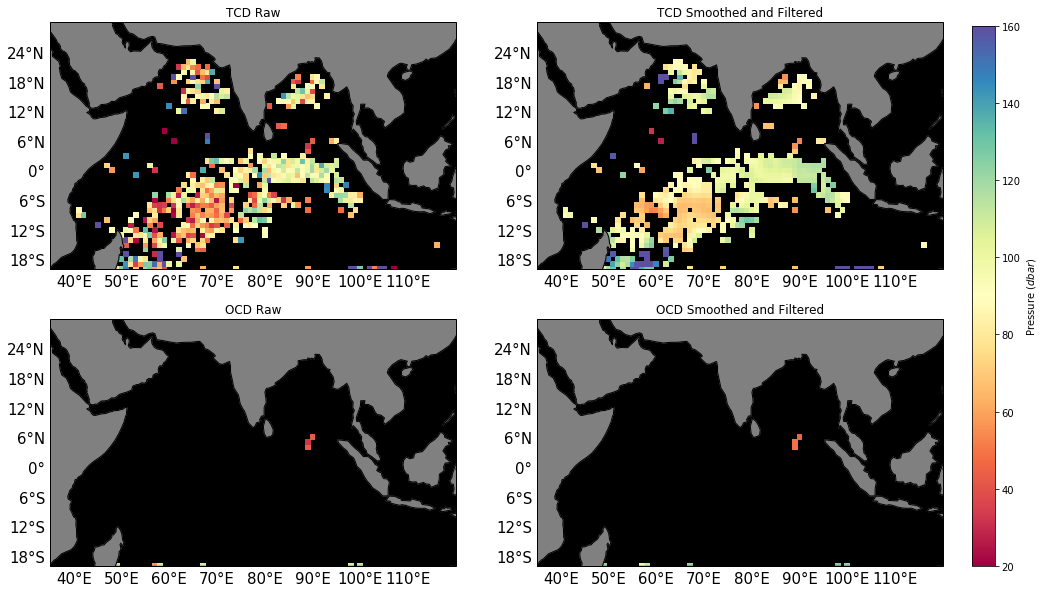

In [202]:
# Plotting
def add_land(ax,bounds):
    from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
    ax.add_feature(cfeature.LAND,color='gray',zorder = 2)
    ax.background_patch.set_facecolor('k')
    ax.coastlines(resolution='110m',zorder = 2)
    g = ax.gridlines(draw_labels=True,alpha=0)
    g.xlabels_top = False
    g.ylabels_right = False
    g.xlabel_style = {'size': 15}
    g.ylabel_style = {'size': 15}
    g.xformatter = LONGITUDE_FORMATTER
    g.yformatter = LATITUDE_FORMATTER
    ax.axes.axis('tight')
    ax.set_extent(bounds, crs=ccrs.PlateCarree())

# limits
cmin = 20
cmax = 160
bounds = [35,120,-20,30]
cmap = plt.cm.Spectral # plt.cm.PuOr

fig, axes = plt.subplots(nrows = 2, ncols = 2,figsize=(16,10),subplot_kw={'projection': ccrs.PlateCarree()})

p = axes[0,0].pcolor(lonp,latp,ds.TCD_binned_ave,cmap=cmap,vmin=cmin,vmax=cmax,
                       transform=ccrs.PlateCarree())
add_land(axes[0,0],bounds)
axes[0,0].set_extent(bounds, crs=ccrs.PlateCarree())
axes[0,0].set_title('TCD Raw')
axes[0,0].set_xlabel('Longitude')
axes[0,0].set_ylabel('Latitude')

p2 = axes[0,1].pcolormesh(lonp,latp,ds.TCD_sm_10_binned_ave_filt,cmap=cmap, vmin=cmin,vmax=cmax,
                       transform=ccrs.PlateCarree())
add_land(axes[0,1],bounds)
axes[0,1].set_title('TCD Smoothed and Filtered')
axes[0,1].set_xlabel('Longitude')

p4 = axes[1,0].pcolormesh(lonp,latp,ds.OCD_binned_ave,cmap=cmap,vmin=cmin,vmax=cmax)
add_land(axes[1,0],bounds)
axes[1,0].set_extent(bounds, crs=ccrs.PlateCarree())
axes[1,0].set_title('OCD Raw')
axes[1,0].set_xlabel('Longitude')
axes[1,0].set_ylabel('Latitude')

p5 = axes[1,1].pcolormesh(lonp,latp,ds.OCD_sm_10_binned_ave_filt,cmap=cmap, vmin=cmin,vmax=cmax,
                       transform=ccrs.PlateCarree())
add_land(axes[1,1],bounds)
axes[1,1].set_title('OCD Smoothed and Filtered')
axes[1,1].set_xlabel('Longitude')


cbar_ax = fig.add_axes([0.925, 0.125, 0.02, 0.75])
cbar = fig.colorbar(p,cax=cbar_ax, pad=0.04)
cbar.set_label('Pressure ($dbar$)')

# Months of lowest TCD and OCD with O and T vals

In [120]:
def latlonbin(TCD,OCD,lat,lon,date,binwidth):
    import numpy as np
    # find TCD anomaly and do correlatinos there.
    # create a pandas dataframe
    df = pd.DataFrame(dict(
            TCD=np.array(TCD),
            OCD=np.array(OCD),
            TCD_masked=np.array(TCD),
            OCD_masked=np.array(OCD),
            lat=np.array(lat),
            lon=np.array(lon),
            date = ds.time,
            prof = np.array(ds.prof)
        ))

    # add in a column for the month
    df['month'] = pd.DatetimeIndex(df['date']).month

    # set to nans all the values where there isn't a tcd and ocd value

    ind = (df['TCD'].isnull()) | (df['OCD'].isnull()) 
    df.loc[(ind),'TCD_masked']=np.nan
    df.loc[(ind),'OCD_masked']=np.nan

    # create 1 degree bins
    binwidth = 1
    # latedges = np.arange(ds.lat.min()-(binwidth/2),ds.lat.max()+(binwidth/2),binwidth)
    latedges = np.arange(ds.lat.min(),ds.lat.max(),binwidth)
    lat_inds = list(range(len(latedges)-1))

    # lonedges = np.arange(ds.lon.min()-(binwidth/2),ds.lon.max()+(binwidth/2),binwidth)
    lonedges = np.arange(ds.lon.min(),ds.lon.max(),binwidth)
    lon_inds = list(range(len(lonedges)-1))

    latbins = latedges[1:]-(binwidth/2)
    lonbins = lonedges[1:]-(binwidth/2)

    df['latedges'] = pd.cut(ds.lat, latedges)
    df['lonedges'] = pd.cut(ds.lon, lonedges)
    df['latbins_ind'] = pd.cut(ds.lat, latedges,labels = lat_inds)
    df['lonbins_ind'] = pd.cut(ds.lon, lonedges,labels = lon_inds)
    df['lat_lon_indx']=df.groupby(['latbins_ind', 'lonbins_ind']).ngroup()
    grouped = df.groupby(['latbins_ind', 'lonbins_ind'])


    min_OCD = np.zeros((len(latbins),len(lonbins)), dtype=np.ndarray)
    min_OCD[:] = np.nan

    min_OCD_month = np.zeros((len(latbins),len(lonbins)), dtype=np.ndarray)
    min_OCD_month[:] = np.nan

    min_TCD = np.zeros((len(latbins),len(lonbins)), dtype=np.ndarray)
    min_TCD[:] = np.nan

    min_TCD_month = np.zeros((len(latbins),len(lonbins)), dtype=np.ndarray)
    min_TCD_month[:] = np.nan

    #extract the data for each group
    for name, group in grouped:
        i = np.array(group.latbins_ind)
        j = np.array(group.lonbins_ind)
        month = np.array(group.month)


        # find month of minimum OCD
        if ~np.isnan(np.nanmin(group.OCD_masked)):
            min_OCD[i[0],j[0]] = np.nanmin(group.OCD_masked)
            ind = np.nanargmin(group.OCD_masked)
            min_OCD_month[i[0],j[0]] = month[ind]
        if ~np.isnan(np.nanmin(group.TCD_masked)): 
            min_TCD[i[0],j[0]] = np.nanmin(group.TCD_masked)
            ind = np.nanargmin(group.TCD_masked)
            min_TCD_month[i[0],j[0]] = month[ind]
            
    # create pcolormesh lat/lon vals
    
    # extend longitude by 2
    lon_extend = np.zeros(lonbins.size+2)
    # fill in internal values
    lon_extend[1:-1] = lonbins # fill up with original values
    # fill in extra endpoints
    lon_extend[0] = lonbins[0]-np.diff(lonbins)[0]
    lon_extend[-1] = lonbins[-1]+np.diff(lonbins)[-1]
    # calculate the midpoints
    lon_pcolormesh_midpoints = lon_extend[:-1]+0.5*(np.diff(lon_extend))

    # extend latitude by 2
    lat_extend = np.zeros(latbins.size+2)
    # fill in internal values
    lat_extend[1:-1] = latbins
    # fill in extra endpoints
    lat_extend[0] = latbins[0]-np.diff(latbins)[0]
    lat_extend[-1] = latbins[-1]+np.diff(latbins)[-1]
    # calculate the midpoints
    lat_pcolormesh_midpoints = lat_extend[:-1]+0.5*(np.diff(lat_extend))

    return(np.array(min_TCD_month,dtype = float), np.array(min_OCD_month,dtype = float),
           lonbins,latbins,lon_pcolormesh_midpoints,lat_pcolormesh_midpoints)

# TCD/OCD Binned
min_TCD_month, min_OCD_month, lonbins, latbins,lonp,latp = latlonbin(ds.TCD,ds.OCD,ds.lat,ds.lon,ds.time,binwidth)

min_TCD_month_sm_10, min_OCD_month_sm_10, lonbins, latbins,lonp,latp = latlonbin(ds.TCD_sm_10,ds.OCD_sm_10,ds.lat,ds.lon,ds.time,binwidth)
   
min_TCD_month_sm_10_filt = gaus_filter_nan(min_TCD_month_sm_10,1)
min_OCD_month_sm_10_filt = gaus_filter_nan(min_OCD_month_sm_10,1)
    
# figure out why it isn't saving correctly to the ds!
    
# ds['min_OCD'] = xr.DataArray(np.array(min_OCD,dtype = float),
#                                    dims = ['latbins','lonbins'],coords =[latbins,lonbins])

# ds['min_OCD_month'] = xr.DataArray(min_OCD_month,
#                                    dims = ['latbins','lonbins'],coords =[latbins,lonbins])


# ds['min_TCD'] = xr.DataArray(np.array(min_TCD,dtype = float),
#                                    dims = ['latbins','lonbins'],coords =[latbins,lonbins])

# ds['min_TCD_month'] = xr.DataArray(np.array(min_TCD_month,dtype = float),
#                                    dims = ['latbins','lonbins'],coords =[latbins,lonbins])

# # add to dataset
# ds['min_TCD_month_sm_10_filt'] = xr.DataArray(gaus_filter_nan(min_TCD_month_sm_10,1),
#                                    dims = ['latbins','lonbins'],coords =[latbins,lonbins])

# ds['min_OCD_month_sm_10_filt'] = xr.DataArray(gaus_filter_nan(min_OCD_month_sm_10,1),
#                                    dims = ['latbins','lonbins'],coords =[latbins,lonbins])

/home/jennap/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: All-NaN axis encountered
/home/jennap/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:70: RuntimeWarning: All-NaN axis encountered
/home/jennap/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: All-NaN axis encountered
/home/jennap/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:70: RuntimeWarning: All-NaN axis encountered


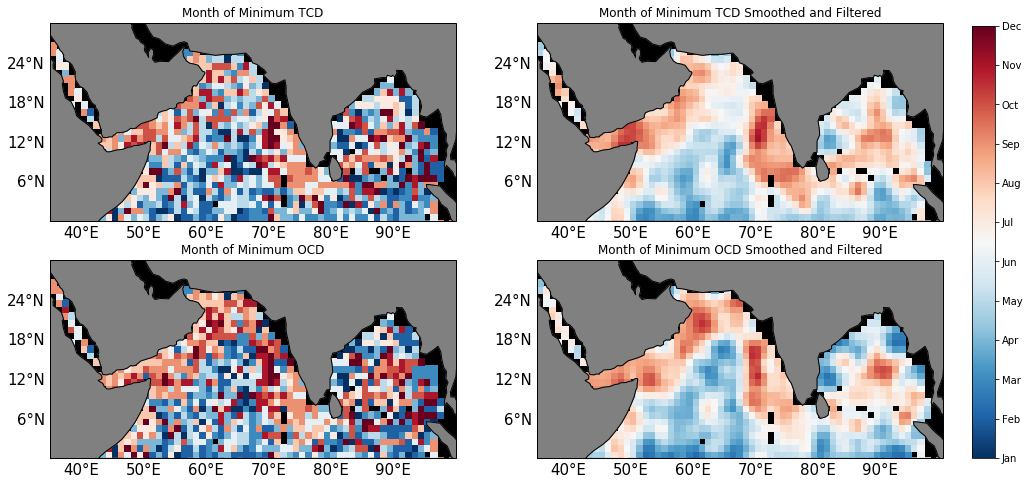

In [127]:
# Plotting
import cmocean

def add_land(ax,bounds):
    from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
    ax.add_feature(cfeature.LAND,color='gray',zorder = 2)
    ax.background_patch.set_facecolor('k')
    ax.coastlines(resolution='110m',zorder = 2)
    g = ax.gridlines(draw_labels=True,alpha=0)
    g.xlabels_top = False
    g.ylabels_right = False
    g.xlabel_style = {'size': 15}
    g.ylabel_style = {'size': 15}
    g.xformatter = LONGITUDE_FORMATTER
    g.yformatter = LATITUDE_FORMATTER
    ax.axes.axis('tight')
    ax.set_extent(bounds, crs=ccrs.PlateCarree())

# limits
cmin = 20
cmax = 160
bounds = [35,100,0,30]
cmap = plt.cm.RdBu_r #cmocean.cm.phase

fig, axes = plt.subplots(nrows = 2, ncols = 2,figsize=(16,8),subplot_kw={'projection': ccrs.PlateCarree()})

p = axes[0,0].pcolor(lonp,latp,min_TCD_month_sm_10,cmap=cmap,
                       transform=ccrs.PlateCarree())
add_land(axes[0,0],bounds)
axes[0,0].set_extent(bounds, crs=ccrs.PlateCarree())
axes[0,0].set_title('Month of Minimum TCD')
axes[0,0].set_xlabel('Longitude')
axes[0,0].set_ylabel('Latitude')

p2 = axes[0,1].pcolormesh(lonp,latp,min_TCD_month_sm_10_filt,cmap=cmap,
                       transform=ccrs.PlateCarree())
add_land(axes[0,1],bounds)
axes[0,1].set_title('Month of Minimum TCD Smoothed and Filtered')
axes[0,1].set_xlabel('Longitude')

p4 = axes[1,0].pcolormesh(lonp,latp,min_OCD_month_sm_10,cmap=cmap,
                       transform=ccrs.PlateCarree())
add_land(axes[1,0],bounds)
axes[1,0].set_title('Month of Minimum OCD')
axes[1,0].set_xlabel('Longitude')
axes[1,0].set_ylabel('Latitude')

p5 = axes[1,1].pcolormesh(lonp,latp,min_OCD_month_sm_10_filt,cmap=cmap,
                       transform=ccrs.PlateCarree())
add_land(axes[1,1],bounds)
axes[1,1].set_title('Month of Minimum OCD Smoothed and Filtered')
axes[1,1].set_xlabel('Longitude')


cbar_ax = fig.add_axes([0.925, 0.125, 0.02, 0.75])
cbar = fig.colorbar(p,cax=cbar_ax, pad=0.04,
                    ticks = np.arange(1,13))
cbar.set_ticklabels(['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'])

## Find Correlations


In [122]:
# # my attempt without pandas
# import itertools

# binwidth = 1
# latedges =  list(np.arange(ds.lat.min()-(binwidth/2),ds.lat.max()+(binwidth/2),binwidth))
# lonedges =  list(np.arange(ds.lon.min()-(binwidth/2),ds.lon.max()+(binwidth/2),binwidth))

# TCD_BINNED = np.zeros((len(latedges),len(lonedges)), dtype=np.ndarray)

# for i in range(len(latedges)-1):
#     for j in range(len(lonedges)-1):
# #         print(i,j)
    
#         ind = (ds.lat>= latedges[i]) & (ds.lat<=latedges[i+1]) & (ds.lon>= lonedges[j]) & (ds.lon<=lonedges[j+1])
        
#         TCD_BINNED[i,j] = np.array(ds.TCD[ind])
#         TCD_binned_ave = np.nanmean(ds.TCD[ind])

# set values to nans for the correlations



In [123]:
# # convert to np array to work with the stats.binned stuff.
# lon = np.array(ds.lon)
# lat = np.array(ds.lat)

# # create 1 degree bins
# latedges = np.r_[ds.lat.min():ds.lat.max():1]
# lonedges = np.r_[ds.lon.min():ds.lon.max():1]

# TCD_binned, yedges, xedges, binnumber = stats.binned_statistic_2d(lat[~np.isnan(TCD)], 
#                                                                  lon[~np.isnan(TCD)], TCD[~np.isnan(TCD)], 
#                                                                  'mean', bins=[latedges, lonedges])
# OCD_binned, yedges, xedges, binnumber = stats.binned_statistic_2d(lat[~np.isnan(OCD)], 
#                                                                  lon[~np.isnan(OCD)], OCD[~np.isnan(OCD)], 
#                                                                  'mean', bins=[latedges, lonedges])

# TCD_sm_10_binned, yedges, xedges, binnumber = stats.binned_statistic_2d(lat[~np.isnan(TCD_sm_10)], 
#                                                                  lon[~np.isnan(TCD_sm_10)], 
#                                                                  TCD_sm_10[~np.isnan(TCD_sm_10)], 
#                                                                  'mean', bins=[latedges, lonedges])

# OCD_sm_10_binned, yedges, xedges, binnumber = stats.binned_statistic_2d(lat[~np.isnan(OCD_sm_10)], 
#                                                                  lon[~np.isnan(OCD_sm_10)], 
#                                                                  OCD_sm_10[~np.isnan(OCD_sm_10)], 
#                                                                  'mean', bins=[latedges, lonedges])

# lonbins = xedges[1:] - 1/2
# latbins = yedges[1:] - 1/2

# # add to dataset
# ds['lonbins'] = xr.DataArray(lonbins,dims = ['lonbins'],coords =[lonbins])
# ds['latbins'] = xr.DataArray(latbins,dims = ['latbins'],coords =[latbins])

# ds['TCD_binned'] = xr.DataArray(TCD_binned,dims = ['latbins','lonbins'],coords =[latbins,lonbins])
# ds['OCD_binned'] = xr.DataArray(OCD_binned,dims = ['latbins','lonbins'],coords =[latbins,lonbins])

# ds['TCD_sm_10_binned'] = xr.DataArray(TCD_sm_10_binned,dims = ['latbins','lonbins'],coords =[latbins,lonbins])
# ds['OCD_sm_10_binned'] = xr.DataArray(OCD_sm_10_binned,dims = ['latbins','lonbins'],coords =[latbins,lonbins])

# # apply a Guassian filter with st = 1 --- figure out how to deal with the coastlines later
# TCD_sm_10_binned_filtered = xr.DataArray(gaussian_filter(ds.TCD_sm_10_binned,
#                                                          sigma=1),coords = [ds.latbins,ds.lonbins])

# OCD_sm_10_binned_filtered = xr.DataArray(gaussian_filter(ds.OCD_sm_10_binned,
#                                                        sigma=1),coords = [ds.latbins,ds.lonbins])
# # add to dataset
# ds['TCD_sm_10_binned_filtered'] = xr.DataArray(TCD_sm_10_binned_filtered,dims = ['latbins','lonbins'],coords =[latbins,lonbins])
# ds['OCD_sm_10_binned_filtered'] = xr.DataArray(OCD_sm_10_binned_filtered,dims = ['latbins','lonbins'],coords =[latbins,lonbins])

In [124]:
# # find TCD anomaly and do correlatinos there.
# # create a pandas dataframe
# df = pd.DataFrame(dict(
#         TCD=np.array(ds.TCD),
#         OCD=np.array(ds.OCD),
#         TCD_masked=np.array(ds.TCD),
#         OCD_masked=np.array(ds.OCD),
#         lat=np.array(ds.lat),
#         lon=np.array(ds.lon),
#         date = ds.time,
#         prof = np.array(ds.prof)
#     ))

# # add in a column for the month
# df['month'] = pd.DatetimeIndex(df['date']).month

# # set to nans all the values where there isn't a tcd and ocd value

# ind = (df['TCD'].isnull()) | (df['OCD'].isnull()) 
# df.loc[(ind),'TCD_masked']=np.nan
# df.loc[(ind),'OCD_masked']=np.nan

# # create 1 degree bins
# binwidth = 1
# # latedges = np.arange(ds.lat.min()-(binwidth/2),ds.lat.max()+(binwidth/2),binwidth)
# latedges = np.arange(ds.lat.min(),ds.lat.max(),binwidth)
# lat_inds = list(range(len(latedges)-1))

# # lonedges = np.arange(ds.lon.min()-(binwidth/2),ds.lon.max()+(binwidth/2),binwidth)
# lonedges = np.arange(ds.lon.min(),ds.lon.max(),binwidth)
# lon_inds = list(range(len(lonedges)-1))

# latbins = latedges[1:]-(binwidth/2)
# lonbins = lonedges[1:]-(binwidth/2)

# df['latedges'] = pd.cut(ds.lat, latedges)
# df['lonedges'] = pd.cut(ds.lon, lonedges)
# df['latbins_ind'] = pd.cut(ds.lat, latedges,labels = lat_inds)
# df['lonbins_ind'] = pd.cut(ds.lon, lonedges,labels = lon_inds)
# df['lat_lon_indx']=df.groupby(['latbins_ind', 'lonbins_ind']).ngroup()
# grouped = df.groupby(['latbins_ind', 'lonbins_ind'])

# TCD_BINNED = np.zeros((len(latbins),len(lonbins)), dtype=np.ndarray)
# TCD_BINNED[:] = np.nan
# OCD_BINNED = np.zeros((len(latbins),len(lonbins)), dtype=np.ndarray)
# OCD_BINNED[:] = np.nan

# TCD_binned_ave = np.zeros((len(latbins),len(lonbins)), dtype=np.ndarray)
# TCD_binned_ave[:] = np.nan

# OCD_binned_ave = np.zeros((len(latbins),len(lonbins)), dtype=np.ndarray)
# OCD_binned_ave[:] = np.nan

# min_OCD = np.zeros((len(latbins),len(lonbins)), dtype=np.ndarray)
# min_OCD[:] = np.nan

# min_OCD_month = np.zeros((len(latbins),len(lonbins)), dtype=np.ndarray)
# min_OCD_month[:] = np.nan

# min_TCD = np.zeros((len(latbins),len(lonbins)), dtype=np.ndarray)
# min_TCD[:] = np.nan

# min_TCD_month = np.zeros((len(latbins),len(lonbins)), dtype=np.ndarray)
# min_TCD_month[:] = np.nan

# #extract the data for each group
# for name, group in grouped:
#     i = np.array(group.latbins_ind)
#     j = np.array(group.lonbins_ind)
#     month = np.array(group.month)
    
#     TCD_BINNED[i[0],j[0]] = group.TCD
#     OCD_BINNED[i[0],j[0]] = group.OCD
    
#     TCD_binned_ave[i[0],j[0]] = np.nanmean(group.TCD)
#     OCD_binned_ave[i[0],j[0]] = np.nanmean(group.OCD)
    
#     # find month of minimum OCD
#     if ~np.isnan(np.nanmin(group.OCD_masked)):
#         min_OCD[i[0],j[0]] = np.nanmin(group.OCD_masked)
#         ind = np.nanargmin(group.OCD_masked)
#         min_OCD_month[i[0],j[0]] = month[ind]
#     if ~np.isnan(np.nanmin(group.TCD_masked)): 
#         min_TCD[i[0],j[0]] = np.nanmin(group.TCD_masked)
#         ind = np.nanargmin(group.TCD_masked)
#         min_TCD_month[i[0],j[0]] = month[ind]
    
#     # find average doxy during month of minmum OCD
    
#     # seasonal correlations
#     # used masked variables
    
# #     scipy.stats.pearsonr(x, y)[source]¶
   